In [1]:
import netCDF4
import xarray as xr
import xesmf as xe
from itertools import cycle
import os
import dask
import numpy as np
import pandas as pd
import dask.array as da
import dask.bag as db
from pykdtree.kdtree import KDTree
from dask.diagnostics import ProgressBar
import subprocess
import matplotlib.pyplot as plt



#check the interpolated file ... why crashing? re-entrant boundary conditions?
#The run is here:
#/home/561/pas561/mom6/mom6-025-panan
#The obc code is here:
#/home/561/pas561/gdv45/jnb/mom6-regional-scripts
#Obc01to025.ipynb
#input:
    - /g/data/jk72/pas561/inputs/mom6/panan-025/

#crash error:
WARNING from PE   672: btstep: eta has dropped below bathyT:  -1.7178436215287191E+05 vs.  -3.4728146972656250E+03 at   7.9875E+01 -4.6138E+01   1441    291

 h<0 at k=           1 h_old=  1.454396947178623E-006 wup=
  0.000000000000000E+000 wdn=  7.484518780074723E-003 dw_dz=
 -7.484518780074723E-003 h_new= -7.483064383127544E-003 h_err=
  1.661897015575669E-018

FATAL from PE   692: MOM_regridding: adjust_interface_motion() - implied h<0 is larger than roundoff!

 h<0 at k=           1 h_old=  1.783345576538204E-006 wup=
 h<0 at k=           1 h_old=  1.493819764307783E-006 wup=
  0.000000000000000E+000 wdn=  7.636576929144212E-004 dw_dz=
  0.000000000000000E+000 wdn=  5.297471592712100E-003 dw_dz=
 -5.297471592712100E-003 h_new= -5.295977772947792E-003 h_err=
  1.176274986905335E-018

In [2]:
# higher-res open boundary forcing
obc01 = xr.open_dataset("/g/data/ik11/inputs/mom6/panan-01/forcing/forcing_obc.nc")
obc025 = xr.open_dataset("025_forcing_obc.nc")

In [3]:
obc01

<xarray.Dataset>
Dimensions:              (time: 365, nz_segment_001_salt: 75,
                          ny_segment_001: 1, nx_segment_001: 7201,
                          nz_segment_001_temp: 75, nz_segment_001_u: 75,
                          nz_segment_001_v: 75)
Coordinates:
  * nx_segment_001       (nx_segment_001) int32 0 2 4 6 ... 14396 14398 14400
  * ny_segment_001       (ny_segment_001) int32 0
  * nz_segment_001_salt  (nz_segment_001_salt) int32 0 1 2 3 4 ... 71 72 73 74
  * nz_segment_001_temp  (nz_segment_001_temp) int32 0 1 2 3 4 ... 71 72 73 74
  * nz_segment_001_u     (nz_segment_001_u) int32 0 1 2 3 4 5 ... 70 71 72 73 74
  * nz_segment_001_v     (nz_segment_001_v) int32 0 1 2 3 4 5 ... 70 71 72 73 74
  * time                 (time) object 1900-01-01 12:00:00 ... 1900-12-31 12:...
Data variables:
    dz_salt_segment_001  (time, nz_segment_001_salt, ny_segment_001, nx_segment_001) float64 ...
    dz_temp_segment_001  (time, nz_segment_001_temp, ny_segment_001, nx_segment_001) float64 ...
    dz_u_segment_001     (time, nz_segment_001_u, ny_segment_001, nx_segment_001) float64 ...
    dz_v_segment_001     (time, nz_segment_001_v, ny_segment_001, nx_segment_001) float64 ...
    eta_t_segment_001    (time, ny_segment_001, nx_segment_001) float64 ...
    ilist_segment_001    (ny_segment_001, nx_segment_001) float64 ...
    jlist_segment_001    (ny_segment_001, nx_segment_001) float64 ...
    salt_segment_001     (time, nz_segment_001_salt, ny_segment_001, nx_segment_001) float64 ...
    temp_segment_001     (time, nz_segment_001_temp, ny_segment_001, nx_segment_001) float64 ...
    u_segment_001        (time, nz_segment_001_u, ny_segment_001, nx_segment_001) float64 ...
    v_segment_001        (time, nz_segment_001_v, ny_segment_001, nx_segment_001) float64 ...
Attributes:
    history:  Wed Sep 15 22:55:58 2021: ncks -d nx_segment_001,,,2 forcing_ob...
    NCO:      netCDF Operators version 4.9.2 (Homepage = http://nco.sf.net, C...

In [4]:
obc025

<xarray.Dataset>
Dimensions:              (time: 365, nz_segment_001_salt: 75,
                          ny_segment_001: 1, nx_segment_001: 2881,
                          nz_segment_001_temp: 75, nz_segment_001_u: 75,
                          nz_segment_001_v: 75)
Coordinates:
  * ny_segment_001       (ny_segment_001) int32 0
  * nz_segment_001_salt  (nz_segment_001_salt) int32 0 1 2 3 4 ... 71 72 73 74
  * nz_segment_001_temp  (nz_segment_001_temp) int32 0 1 2 3 4 ... 71 72 73 74
  * nz_segment_001_u     (nz_segment_001_u) int32 0 1 2 3 4 5 ... 70 71 72 73 74
  * nz_segment_001_v     (nz_segment_001_v) int32 0 1 2 3 4 5 ... 70 71 72 73 74
  * time                 (time) object 1900-01-01 12:00:00 ... 1900-12-31 12:...
  * nx_segment_001       (nx_segment_001) float64 -280.0 -279.9 ... 79.88 80.0
Data variables:
    dz_salt_segment_001  (time, nz_segment_001_salt, ny_segment_001, nx_segment_001) float64 ...
    dz_temp_segment_001  (time, nz_segment_001_temp, ny_segment_001, nx_segment_001) float64 ...
    dz_u_segment_001     (time, nz_segment_001_u, ny_segment_001, nx_segment_001) float64 ...
    dz_v_segment_001     (time, nz_segment_001_v, ny_segment_001, nx_segment_001) float64 ...
    eta_t_segment_001    (time, ny_segment_001, nx_segment_001) float64 ...
    ilist_segment_001    (ny_segment_001, nx_segment_001) float64 ...
    jlist_segment_001    (ny_segment_001, nx_segment_001) float64 ...
    salt_segment_001     (time, nz_segment_001_salt, ny_segment_001, nx_segment_001) float64 ...
    temp_segment_001     (time, nz_segment_001_temp, ny_segment_001, nx_segment_001) float64 ...
    u_segment_001        (time, nz_segment_001_u, ny_segment_001, nx_segment_001) float64 ...
    v_segment_001        (time, nz_segment_001_v, ny_segment_001, nx_segment_001) float64 ...
Attributes:
    history:  Wed Sep 15 22:55:58 2021: ncks -d nx_segment_001,,,2 forcing_ob...
    NCO:      netCDF Operators version 4.9.2 (Homepage = http://nco.sf.net, C...

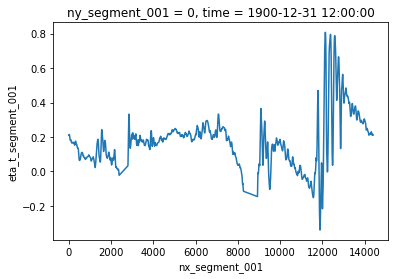

In [18]:
obc01.eta_t_segment_001[364].plot()

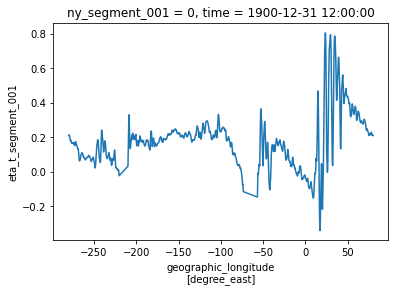

In [15]:
obc025.eta_t_segment_001[364].plot()

In [19]:
obc01.dz_salt_segment_001

<xarray.DataArray 'dz_salt_segment_001' (time: 365, nz_segment_001_salt: 75,
                                         ny_segment_001: 1, nx_segment_001: 7201)>
[197127375 values with dtype=float64]
Coordinates:
  * nx_segment_001       (nx_segment_001) int32 0 2 4 6 ... 14396 14398 14400
  * ny_segment_001       (ny_segment_001) int32 0
  * nz_segment_001_salt  (nz_segment_001_salt) int32 0 1 2 3 4 ... 71 72 73 74
  * time                 (time) object 1900-01-01 12:00:00 ... 1900-12-31 12:...

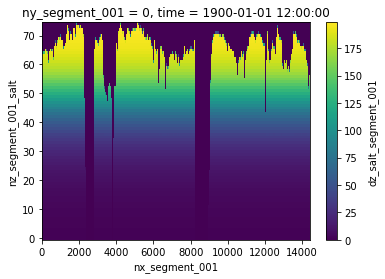

In [11]:
obc01.dz_salt_segment_001[0].plot()

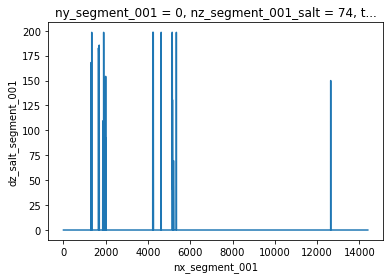

In [23]:
obc01.dz_salt_segment_001.isel(time=364,nz_segment_001_salt=74).plot()

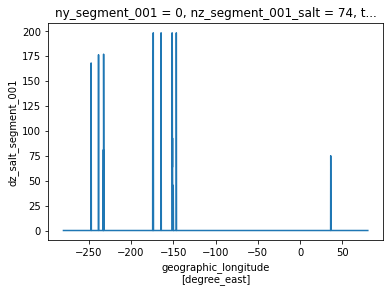

In [24]:
obc025.dz_salt_segment_001.isel(time=364,nz_segment_001_salt=74).plot()

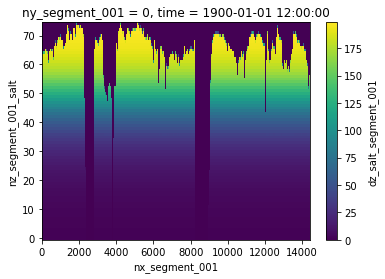

In [25]:
obc01.dz_salt_segment_001.isel(time=0).plot()

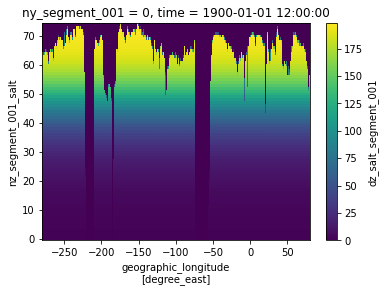

In [26]:
obc025.dz_salt_segment_001.isel(time=0).plot()

In [31]:
obc025.ny_segment_001

<xarray.DataArray 'ny_segment_001' (ny_segment_001: 1)>
array([0], dtype=int32)
Coordinates:
  * ny_segment_001  (ny_segment_001) int32 0

In [32]:
obc01.ny_segment_001

<xarray.DataArray 'ny_segment_001' (ny_segment_001: 1)>
array([0], dtype=int32)
Coordinates:
  * ny_segment_001  (ny_segment_001) int32 0

In [6]:
#this works to get the obc file interpolated ... but the model crashes
#/home/561/pas561/mom6/mom6-025-panan

import xarray as xr

# higher-res open boundary forcing
obc01 = xr.open_dataset("/g/data/ik11/inputs/mom6/panan-01/forcing/forcing_obc.nc")

# source coordinates
hgrid01 = xr.open_dataset("/g/data/ik11/inputs/mom6/panan-01/ocean_hgrid.nc")
boundary01 = hgrid01.x.isel(nyp=-1)
obc01.coords["nx_segment_001"] = boundary01 #.x

# destination coordinates
hgrid025 = xr.open_dataset("/g/data/v45/pas561/mom6-025-panan_hgrid.nc")
boundary025 = hgrid025.x.isel(nyp=-1)

# demonstrate 1D interpolation (first timestep only)
tmp=obc01.isel(time=0).interp(nx_segment_001=boundary025.values)

In [1]:
#xesm regridding ... doesn't like to do 1D ... bastards

#https://github.com/COSIMA/mom6-panan/issues/16
#https://github.com/COSIMA/mom6-regional-scripts/blob/master/brushcut_xesmf_zarr.py

from itertools import cycle
import os

import dask.array as da
import dask.bag as db
import netCDF4
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe

from dask.distributed import Client, worker_client
from dask.diagnostics import ProgressBar

"""
Configurable variables:
base:
  This is the base directory that holds the data from the
  *prepare_segments* script. The value of this variable should match
  between these two scripts.
hgrid_path:
  This points to the ocean_hgrid.nc file for your regional domain.
weights_exist:
  If you have run this script before, and have the regridding weights
  saved, you can save a bit of time by skipping their
  regeneration. Otherwise, leave this as false.
"""

#base = os.getenv("PBS_JOBFS")

'\nConfigurable variables:\nbase:\n  This is the base directory that holds the data from the\n  *prepare_segments* script. The value of this variable should match\n  between these two scripts.\nhgrid_path:\n  This points to the ocean_hgrid.nc file for your regional domain.\nweights_exist:\n  If you have run this script before, and have the regridding weights\n  saved, you can save a bit of time by skipping their\n  regeneration. Otherwise, leave this as false.\n'

In [2]:
#use the BCs from the PanAn-01 and regrid to 025 OBC conditions
#this file doesn't have lat and lon - get from hgrid file - x var for last nyp and all nxp
# just need to rgrid the nx_segments to 025 grid, vertical is fine
# use xesmf with regridder passing in the 01 and 025 segments
obc01_path = "/g/data/ik11/inputs/mom6/panan-01/forcing/forcing_obc.nc"

obc01=xr.open_dataset(obc01_path)
obc01

<xarray.Dataset>
Dimensions:              (time: 365, nz_segment_001_salt: 75,
                          ny_segment_001: 1, nx_segment_001: 7201,
                          nz_segment_001_temp: 75, nz_segment_001_u: 75,
                          nz_segment_001_v: 75)
Coordinates:
  * nx_segment_001       (nx_segment_001) int32 0 2 4 6 ... 14396 14398 14400
  * ny_segment_001       (ny_segment_001) int32 0
  * nz_segment_001_salt  (nz_segment_001_salt) int32 0 1 2 3 4 ... 71 72 73 74
  * nz_segment_001_temp  (nz_segment_001_temp) int32 0 1 2 3 4 ... 71 72 73 74
  * nz_segment_001_u     (nz_segment_001_u) int32 0 1 2 3 4 5 ... 70 71 72 73 74
  * nz_segment_001_v     (nz_segment_001_v) int32 0 1 2 3 4 5 ... 70 71 72 73 74
  * time                 (time) object 1900-01-01 12:00:00 ... 1900-12-31 12:...
Data variables:
    dz_salt_segment_001  (time, nz_segment_001_salt, ny_segment_001, nx_segment_001) float64 ...
    dz_temp_segment_001  (time, nz_segment_001_temp, ny_segment_001, nx_segment_001) float64 ...
    dz_u_segment_001     (time, nz_segment_001_u, ny_segment_001, nx_segment_001) float64 ...
    dz_v_segment_001     (time, nz_segment_001_v, ny_segment_001, nx_segment_001) float64 ...
    eta_t_segment_001    (time, ny_segment_001, nx_segment_001) float64 ...
    ilist_segment_001    (ny_segment_001, nx_segment_001) float64 ...
    jlist_segment_001    (ny_segment_001, nx_segment_001) float64 ...
    salt_segment_001     (time, nz_segment_001_salt, ny_segment_001, nx_segment_001) float64 ...
    temp_segment_001     (time, nz_segment_001_temp, ny_segment_001, nx_segment_001) float64 ...
    u_segment_001        (time, nz_segment_001_u, ny_segment_001, nx_segment_001) float64 ...
    v_segment_001        (time, nz_segment_001_v, ny_segment_001, nx_segment_001) float64 ...
Attributes:
    history:  Wed Sep 15 22:55:58 2021: ncks -d nx_segment_001,,,2 forcing_ob...
    NCO:      netCDF Operators version 4.9.2 (Homepage = http://nco.sf.net, C...

In [16]:
obc01.ny_segment_001

<xarray.DataArray 'ny_segment_001' (ny_segment_001: 1)>
array([0], dtype=int32)
Coordinates:
  * ny_segment_001  (ny_segment_001) int32 0

In [3]:
#get lon data from 01 hgrid file
hgrid01_path = "/g/data/ik11/inputs/mom6/panan-01/ocean_hgrid.nc"
hgrid01=xr.open_dataset(hgrid01_path)
hgrid01

<xarray.Dataset>
Dimensions:   (nyp: 1691, nxp: 7201, nx: 7200, ny: 1690)
Dimensions without coordinates: nyp, nxp, nx, ny
Data variables:
    tile      |S255 ...
    x         (nyp, nxp) float64 ...
    y         (nyp, nxp) float64 ...
    dx        (nyp, nx) float64 ...
    dy        (ny, nxp) float64 ...
    angle_dx  (nyp, nxp) float64 ...
    area      (ny, nx) float64 ...

In [4]:
x01_slice_lons=hgrid01.x[1690,:].load()
x01_slice_lons

<xarray.DataArray 'x' (nxp: 7201)>
array([-280.  , -279.95, -279.9 , ...,   79.9 ,   79.95,   80.  ])
Dimensions without coordinates: nxp
Attributes:
    standard_name:  geographic_longitude
    units:          degree_east

In [32]:
x01_slice_lats=hgrid01.y[1690,:].load()
x01_slice_lats

<xarray.DataArray 'y' (nxp: 7201)>
array([-37.09803061, -37.09803061, -37.09803061, ..., -37.09803061,
       -37.09803061, -37.09803061])
Dimensions without coordinates: nxp
Attributes:
    standard_name:  geographic_latitude
    units:          degree_north

In [18]:
#get lon data from 01 hgrid file
hgrid025_path = "/g/data/jk72/pas561/inputs/mom6/panan-025/mom6-025-panan_hgrid.nc" #"/g/data/x77/ahg157/inputs/mom6/eac-01/hgrid_01.nc"
hgrid025=xr.open_dataset(hgrid025_path)
hgrid025

<xarray.Dataset>
Dimensions:   (nyp: 677, nxp: 2881, nx: 2880, ny: 676)
Dimensions without coordinates: nyp, nxp, nx, ny
Data variables:
    tile      |S255 ...
    x         (nyp, nxp) float64 ...
    y         (nyp, nxp) float64 ...
    dx        (nyp, nx) float64 ...
    dy        (ny, nxp) float64 ...
    angle_dx  (nyp, nxp) float64 ...
    area      (ny, nx) float64 ...

In [21]:
x025_slice_lons=hgrid025.x[676,:].load()
x025_slice_lons

<xarray.DataArray 'x' (nxp: 2881)>
array([-280.   , -279.875, -279.75 , ...,   79.75 ,   79.875,   80.   ])
Dimensions without coordinates: nxp
Attributes:
    standard_name:  geographic_longitude
    units:          degree_east

In [68]:
x025_slice_lats=hgrid025.y[676,:].load()
print(x025_slice_lats)
x025_slice_lats[:]=hgrid01.y[1690,0].data
x025_slice_lats

<xarray.DataArray 'y' (nxp: 2881)>
array([-37.09803741, -37.09803741, -37.09803741, ..., -37.09803741,
       -37.09803741, -37.09803741])
Dimensions without coordinates: nxp
Attributes:
    standard_name:  geographic_latitude
    units:          degree_north


<xarray.DataArray 'y' (nxp: 2881)>
array([-37.09803061, -37.09803061, -37.09803061, ..., -37.09803061,
       -37.09803061, -37.09803061])
Dimensions without coordinates: nxp
Attributes:
    standard_name:  geographic_latitude
    units:          degree_north

In [47]:
hgrid025.y[676,:]

<xarray.DataArray 'y' (nxp: 2881)>
array([-37.098037, -37.098037, -37.098037, ..., -37.098037, -37.098037,
       -37.098037])
Dimensions without coordinates: nxp
Attributes:
    standard_name:  geographic_latitude
    units:          degree_north

In [56]:
dg_out = xr.Dataset(
        {
            "lat": (["location"], x025_slice_lats.data),
            "lon": (["location"], x025_slice_lons.data+100),
        }
    )
dg_out

<xarray.Dataset>
Dimensions:  (location: 2881)
Dimensions without coordinates: location
Data variables:
    lat      (location) float64 -37.1 -37.1 -37.1 -37.1 ... -37.1 -37.1 -37.1
    lon      (location) float64 -180.0 -179.9 -179.8 ... 179.8 179.9 180.0

In [57]:
dg_in = xr.Dataset(
        {
            "lat": (["location"], x01_slice_lats.data),
            "lon": (["location"], x01_slice_lons.data+100),
        }
    )
dg_in

<xarray.Dataset>
Dimensions:  (location: 7201)
Dimensions without coordinates: location
Data variables:
    lat      (location) float64 -37.1 -37.1 -37.1 -37.1 ... -37.1 -37.1 -37.1
    lon      (location) float64 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0

In [69]:
dg_in.lon

<xarray.DataArray 'lon' (location: 7201)>
array([-180.  , -179.95, -179.9 , ...,  179.9 ,  179.95,  180.  ])
Dimensions without coordinates: location

In [70]:
dg_out.lon

<xarray.DataArray 'lon' (location: 2881)>
array([-180.   , -179.875, -179.75 , ...,  179.75 ,  179.875,  180.   ])
Dimensions without coordinates: location

In [71]:
dg_in

<xarray.Dataset>
Dimensions:  (location: 7201)
Dimensions without coordinates: location
Data variables:
    lat      (location) float64 -37.1 -37.1 -37.1 -37.1 ... -37.1 -37.1 -37.1
    lon      (location) float64 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0

In [72]:
dg_out

<xarray.Dataset>
Dimensions:  (location: 2881)
Dimensions without coordinates: location
Data variables:
    lat      (location) float64 -37.1 -37.1 -37.1 -37.1 ... -37.1 -37.1 -37.1
    lon      (location) float64 -180.0 -179.9 -179.8 ... 179.8 179.9 180.0

In [60]:
#now use xesmf to regrid 01 obc to 025 - based on the slice dims above
#obc01_path = "/g/data/ik11/inputs/mom6/panan-01/forcing/forcing_obc.nc"


# create the regridding weights between our grids
# note: reuse_weights should be False unless the weights files
#       do indeed exist!
weights_exist = False

#turns out that xesm doesn't do 1D regriddring ... to simple for its fancy act !!!! I hate python!!!

regridder_tracer = xe.Regridder(
    dg_in,
    dg_out,
    "bilinear",
    locstream_out=True,
    reuse_weights=weights_exist,
    filename="bilinear_tracer_weights_01to025obc.nc",
)

ValueError: ESMC_FieldRegridStore failed with rc = 506. Please check the log files (named "*ESMF_LogFile").

In [55]:
dg_in.lon[-1]

<xarray.DataArray 'lon' ()>
array(80.)

In [9]:
tmp

<xarray.Dataset>
Dimensions:              (nz_segment_001_salt: 75, ny_segment_001: 1,
                          nx_segment_001: 2881, nz_segment_001_temp: 75,
                          nz_segment_001_u: 75, nz_segment_001_v: 75)
Coordinates:
  * ny_segment_001       (ny_segment_001) int32 0
  * nz_segment_001_salt  (nz_segment_001_salt) int32 0 1 2 3 4 ... 71 72 73 74
  * nz_segment_001_temp  (nz_segment_001_temp) int32 0 1 2 3 4 ... 71 72 73 74
  * nz_segment_001_u     (nz_segment_001_u) int32 0 1 2 3 4 5 ... 70 71 72 73 74
  * nz_segment_001_v     (nz_segment_001_v) int32 0 1 2 3 4 5 ... 70 71 72 73 74
    time                 object 1900-01-01 12:00:00
  * nx_segment_001       (nx_segment_001) float64 -280.0 -279.9 ... 79.88 80.0
Data variables:
    dz_salt_segment_001  (nz_segment_001_salt, ny_segment_001, nx_segment_001) float64 ...
    dz_temp_segment_001  (nz_segment_001_temp, ny_segment_001, nx_segment_001) float64 ...
    dz_u_segment_001     (nz_segment_001_u, ny_segment_001, nx_segment_001) float64 ...
    dz_v_segment_001     (nz_segment_001_v, ny_segment_001, nx_segment_001) float64 ...
    eta_t_segment_001    (ny_segment_001, nx_segment_001) float64 0.2136 ... ...
    ilist_segment_001    (ny_segment_001, nx_segment_001) float64 0.0 ... 7.2...
    jlist_segment_001    (ny_segment_001, nx_segment_001) float64 1.942e+03 ....
    salt_segment_001     (nz_segment_001_salt, ny_segment_001, nx_segment_001) float64 ...
    temp_segment_001     (nz_segment_001_temp, ny_segment_001, nx_segment_001) float64 ...
    u_segment_001        (nz_segment_001_u, ny_segment_001, nx_segment_001) float64 ...
    v_segment_001        (nz_segment_001_v, ny_segment_001, nx_segment_001) float64 ...
Attributes:
    history:  Wed Sep 15 22:55:58 2021: ncks -d nx_segment_001,,,2 forcing_ob...
    NCO:      netCDF Operators version 4.9.2 (Homepage = http://nco.sf.net, C...

In [10]:
obc025=obc01.interp(nx_segment_001=boundary025.values)

In [11]:
obc025

<xarray.Dataset>
Dimensions:              (time: 365, nz_segment_001_salt: 75,
                          ny_segment_001: 1, nx_segment_001: 2881,
                          nz_segment_001_temp: 75, nz_segment_001_u: 75,
                          nz_segment_001_v: 75)
Coordinates:
  * ny_segment_001       (ny_segment_001) int32 0
  * nz_segment_001_salt  (nz_segment_001_salt) int32 0 1 2 3 4 ... 71 72 73 74
  * nz_segment_001_temp  (nz_segment_001_temp) int32 0 1 2 3 4 ... 71 72 73 74
  * nz_segment_001_u     (nz_segment_001_u) int32 0 1 2 3 4 5 ... 70 71 72 73 74
  * nz_segment_001_v     (nz_segment_001_v) int32 0 1 2 3 4 5 ... 70 71 72 73 74
  * time                 (time) object 1900-01-01 12:00:00 ... 1900-12-31 12:...
  * nx_segment_001       (nx_segment_001) float64 -280.0 -279.9 ... 79.88 80.0
Data variables:
    dz_salt_segment_001  (time, nz_segment_001_salt, ny_segment_001, nx_segment_001) float64 ...
    dz_temp_segment_001  (time, nz_segment_001_temp, ny_segment_001, nx_segment_001) float64 ...
    dz_u_segment_001     (time, nz_segment_001_u, ny_segment_001, nx_segment_001) float64 ...
    dz_v_segment_001     (time, nz_segment_001_v, ny_segment_001, nx_segment_001) float64 ...
    eta_t_segment_001    (time, ny_segment_001, nx_segment_001) float64 0.213...
    ilist_segment_001    (ny_segment_001, nx_segment_001) float64 0.0 ... 7.2...
    jlist_segment_001    (ny_segment_001, nx_segment_001) float64 1.942e+03 ....
    salt_segment_001     (time, nz_segment_001_salt, ny_segment_001, nx_segment_001) float64 ...
    temp_segment_001     (time, nz_segment_001_temp, ny_segment_001, nx_segment_001) float64 ...
    u_segment_001        (time, nz_segment_001_u, ny_segment_001, nx_segment_001) float64 ...
    v_segment_001        (time, nz_segment_001_v, ny_segment_001, nx_segment_001) float64 ...
Attributes:
    history:  Wed Sep 15 22:55:58 2021: ncks -d nx_segment_001,,,2 forcing_ob...
    NCO:      netCDF Operators version 4.9.2 (Homepage = http://nco.sf.net, C...

In [12]:
obc025.to_netcdf('025_forcing_obc.nc')